# 1. Hyperparameter optimization

To install Optuna: run `pip install optuna` in console after activating your environment.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import optuna
import optuna.visualization as vis

seed = 42
torch.manual_seed(seed)

/home/percy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load MNIST data. **DO NOT CHANGE THIS.**

In [2]:
def get_mnist_loaders(batch_size, valid_ratio, seed, downsample_ratio):
    # Define the transformation: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load the full training set (train=True returns the 60k training images)
    train_dataset = torchvision.datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=transform
    )
    
    # Optionally downsample the training data
    if downsample_ratio < 1.0:
        subset_size = int(len(train_dataset) * downsample_ratio)
        indices = list(range(subset_size))
        train_dataset = Subset(train_dataset, indices)
    
    # Load the test set (train=False returns the 10k testing images)
    test_dataset = torchvision.datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transform
    )
    
    # Split training set into training and validation set
    train_size = int((1.0 - valid_ratio) * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    gen = torch.Generator().manual_seed(seed)
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size], generator=gen)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader, test_loader

batch_size = 128
valid_ratio = 0.2
downsample_ratio = 0.5

# Create the DataLoaders
train_loader, valid_loader, test_loader = get_mnist_loaders(batch_size=batch_size, 
                                                              valid_ratio=valid_ratio, 
                                                              seed=seed,
                                                              downsample_ratio=downsample_ratio)

# Total number of images in each dataset
print("Total training images:", len(train_loader.dataset))
print("Total validation images:", len(valid_loader.dataset))
print("Total test images:", len(test_loader.dataset))

Total training images: 24000
Total validation images: 6000
Total test images: 10000


## (1a) Implement CNN

Write here the network structure as described in the exercise sheet.

Remember to **make the kernel size a parameter**, so that it can be controlled later.

In [3]:
class CNN(nn.Module):
	# TODO
	def __init__(self, kernel_size):
		super(CNN, self).__init__()

		self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = kernel_size)
		conv_output_size = 28 - kernel_size + 1
		max_pooled_size = conv_output_size // 2
		self.flat_size = 16 * max_pooled_size ** 2
		self.fc1 = nn.Linear(in_features = self.flat_size, out_features = 32)
		self.fc2 = nn.Linear(in_features = 32, out_features = 10)

	def forward(self, x):
			# 1st layer 	
			first_layer_out = F.relu(input = self.conv1(x))
			# max pool layer
			max_pool_layer_out = F.max_pool2d(input = first_layer_out, kernel_size = 2, stride = 2).view(-1, self.flat_size)
			# 3rd layer
			x = F.relu(input = self.fc1(max_pool_layer_out))
			# 4th layer
			return F.log_softmax(input = self.fc2(x), dim = 1)

#### (1b & 1c) Train&Test Functions

To help focus on tuning optimizers and networks, we provided 3 pre-written functions for training and testing.

By having clear functions, we can easily compare different settings and keep the process consistent.

**You do not need to change anything in this part.**

In [4]:
# Training function.
def train(net, train_loader, parameters, epochs=1):
    optimizer = torch.optim.SGD(net.parameters(), lr=parameters["lr"], momentum=parameters["momentum"])
    criterion = nn.NLLLoss()
    net.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return net

# Evaluation function.
def evaluate(net, data_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = net(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

# Function for final training using best params on combined train and validation sets, then testing.
def train_test(parameters):
    combined_dataset = ConcatDataset([train_loader.dataset, valid_loader.dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    
    net = CNN(kernel_size=parameters["kernel_size"])
    net = train(net, combined_loader, parameters)
    test_accuracy = evaluate(net, test_loader)
    return test_accuracy

## (1b) Bayesian optimization using Optuna

Optuna requires an objective for the optimization.

Our objective returns validation accuracy, and we use **direction="maximize".**

So, we aim to maximize the accuracy of the validation dataset.

**Here, your task is to define the hyperparameter search spaces** (suggested hyperparameters).

Here you can see the documentary page for search spaces:

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html

In [5]:
def objective(trial):
    # Define hyperparameter search spaces.
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=False) # TODO
    momentum = trial.suggest_float('momentum', 0.0, 1.0) # TODO
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5, 7]) # TODO
    parameters = {"lr": lr, "momentum": momentum, "kernel_size": kernel_size}
    
    # Initialize the model with the chosen kernel_size.
    net = CNN(kernel_size=kernel_size)
    
    # Train the model on the training set.
    net = train(net, train_loader, parameters)
    
    # Evaluate validation sets.
    val_accuracy = evaluate(net, valid_loader)
    
    # Return the validation accuracy (this is what we want to maximize).
    return val_accuracy

# Create Optuna study and optimize.
n_trials = 75
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=n_trials)

print("Best hyperparameters:", study.best_trial.params)
print("Best validation accuracy:", study.best_trial.value)

[I 2025-04-07 19:32:00,520] A new study created in memory with name: no-name-19e35073-8c3c-4288-823d-93e68b4c1f12
[I 2025-04-07 19:32:07,290] Trial 0 finished with value: 0.9065 and parameters: {'lr': 0.0037460266483547782, 'momentum': 0.9507143064099162, 'kernel_size': 3}. Best is trial 0 with value: 0.9065.
[I 2025-04-07 19:32:13,881] Trial 1 finished with value: 0.6105 and parameters: {'lr': 0.0015607892088416904, 'momentum': 0.05808361216819946, 'kernel_size': 3}. Best is trial 0 with value: 0.9065.
[I 2025-04-07 19:32:20,438] Trial 2 finished with value: 0.7906666666666666 and parameters: {'lr': 0.00020682435846372868, 'momentum': 0.9699098521619943, 'kernel_size': 3}. Best is trial 0 with value: 0.9065.
[I 2025-04-07 19:32:26,971] Trial 3 finished with value: 0.735 and parameters: {'lr': 0.001834861694024485, 'momentum': 0.3042422429595377, 'kernel_size': 3}. Best is trial 0 with value: 0.9065.
[I 2025-04-07 19:32:33,446] Trial 4 finished with value: 0.8556666666666667 and parame

Best hyperparameters: {'lr': 0.00787673599927805, 'momentum': 0.971443127891242, 'kernel_size': 5}
Best validation accuracy: 0.956


/tmp/ipykernel_2500199/761169017.py:6: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



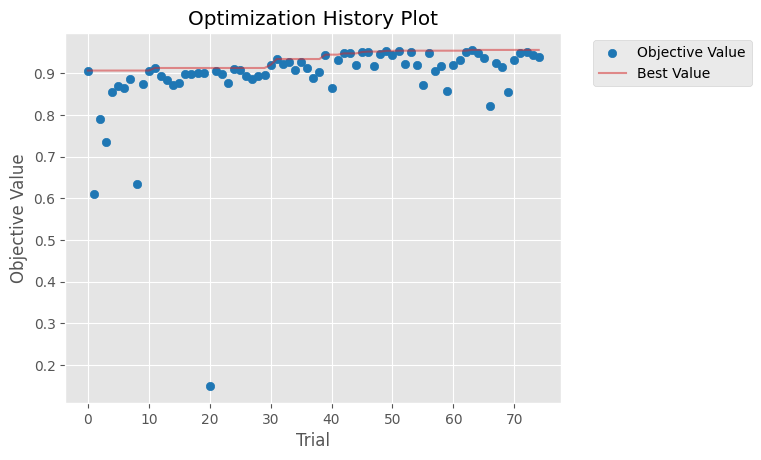

In [6]:
# Visualize the optimization history. (Interactive)
fig_history = vis.plot_optimization_history(study)
fig_history.show()

# Alternative Visualization. You can use this if the plot is not visible in .pdf version (Matplotlib plot)
fig_history = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [7]:
# Evaluate on the test set using the best hyperparameters.
test_accuracy = train_test(study.best_trial.params)
print("Test accuracy with best hyperparameters:", test_accuracy)

Test accuracy with best hyperparameters: 0.9678


## (1c) Grid search

Implement grid search for the same three parameters.

Remember that you **need to cover 75 alternatives in total.**

So, think about how to best allocate those to cover the three hyperparameters.

In [8]:
# TODO
learning_rates = np.linspace(0.0001, 0.1, 5)
momentums = np.linspace(0.75, 0.80, 5)
kernel_sizes = [3, 5, 7]

best_accuracy = 0
best_params = {}
grid_results = []
best_grid_results = [] 

iteration = 0
for lr in learning_rates:
	for momentum in momentums:
		for kernel_size in kernel_sizes:
			iteration += 1
			params = {
				"lr": lr
				,"momentum": momentum
				,"kernel_size": kernel_size
			} 
			net = CNN(kernel_size = kernel_size)
			net = train(net, train_loader, params)
			val_accuracy = evaluate(net, valid_loader)
			
			# Keep track of best
			if val_accuracy > best_accuracy:
				best_accuracy = val_accuracy
				best_params = {
					'lr': lr,
					'momentum': momentum,
					'kernel_size': kernel_size
				}
			grid_results.append((iteration, val_accuracy))
			best_grid_results.append((iteration, best_accuracy))
			print(f"iteration: {iteration}, params: {params}, val_accuracy: {val_accuracy}")
print(f"best params: {best_params}")

iteration: 1, params: {'lr': 0.0001, 'momentum': 0.75, 'kernel_size': 3}, val_accuracy: 0.3318333333333333
iteration: 2, params: {'lr': 0.0001, 'momentum': 0.75, 'kernel_size': 5}, val_accuracy: 0.2745
iteration: 3, params: {'lr': 0.0001, 'momentum': 0.75, 'kernel_size': 7}, val_accuracy: 0.1965
iteration: 4, params: {'lr': 0.0001, 'momentum': 0.7625, 'kernel_size': 3}, val_accuracy: 0.176
iteration: 5, params: {'lr': 0.0001, 'momentum': 0.7625, 'kernel_size': 5}, val_accuracy: 0.4605
iteration: 6, params: {'lr': 0.0001, 'momentum': 0.7625, 'kernel_size': 7}, val_accuracy: 0.2605
iteration: 7, params: {'lr': 0.0001, 'momentum': 0.775, 'kernel_size': 3}, val_accuracy: 0.2931666666666667
iteration: 8, params: {'lr': 0.0001, 'momentum': 0.775, 'kernel_size': 5}, val_accuracy: 0.23683333333333334
iteration: 9, params: {'lr': 0.0001, 'momentum': 0.775, 'kernel_size': 7}, val_accuracy: 0.21933333333333332
iteration: 10, params: {'lr': 0.0001, 'momentum': 0.7875000000000001, 'kernel_size': 3}

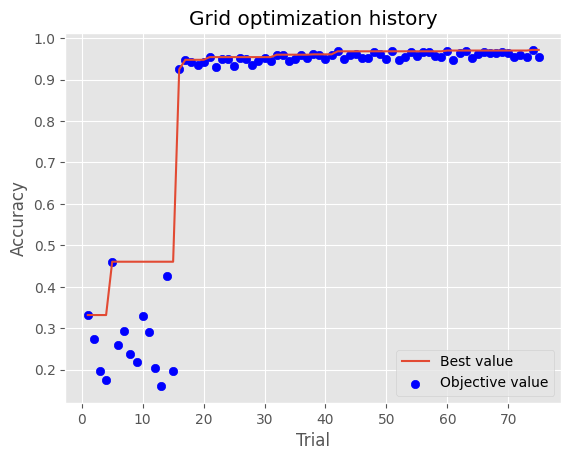

In [9]:
best_grid_x, best_grid_y = zip(*best_grid_results)
grid_x, grid_y = zip(*grid_results)
plt.plot(best_grid_x, best_grid_y, label = "Best value")
plt.scatter(grid_x, grid_y, label = "Objective value", c = "blue")
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.title('Grid optimization history')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Evaluate on the test set using the best hyperparameters.
test_accuracy = train_test(best_params)
print(f"Test accuracy with best hyperparameters: {test_accuracy}, best hyperparameters: {best_params}")

Test accuracy with best hyperparameters: 0.9589, best hyperparameters: {'lr': 0.1, 'momentum': 0.8, 'kernel_size': 5}


After finding the right region of the hyperparameters (lr around 0.1, momentum around 0.7-0.8, kernel size between 5 and 7) I was able to reduce the search space drastically resulting in a better accuracy test for the GridSearch algorithm 0.9589 (0.9735 in a previous run) compared to roughly 0.956 for Bayesian search. The number of iterations, 75, is the same for both methods therefore the time required to complete both methods is roughly the same. Although using GridSeach can be time consuming without prior knowledge of where to look for, the close to best hyperparameters can be obtained through a combination of Bayesian search and GridSearch. 

The number of hyperparameters we can search depends highly on the network we are training since the evaluation of it is the bottleneck of the method. If we assume that the model is the same we can see that for 3 hyperparameters the total time required is already in the order of minutes (using cpu). Knowing that the time complexity for GridSearch is exponential we cannot expect to optimize more than 4-5. On the other hand for Bayesian search a rule of thumb is to have at least 10-20 iterations per hyperparameter therefore we can optimize many more (eg. for 75 iterations we could have optimized 4-8 hyperparameters).

# 2. Transfer learning

In [11]:
import random

seed = 42
torch.manual_seed(seed)
random.seed(seed)

Model - **DO NOT CHANGE THIS**

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Block 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2)

        # Block 2
        self.cnn2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2)

        # Block 3
        self.cnn3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(576, 10)  # Fully connected layer

    def forward(self, x):
        out = self.MaxPool1(self.bn1(self.relu1(self.cnn1(x))))
        out = self.MaxPool2(self.bn2(self.relu2(self.cnn2(out))))
        out = self.MaxPool3(self.bn3(self.relu3(self.cnn3(out))))

        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out

Load Fashion-MNIST data. 128 training samples, 10k test samples. **DO NOT CHANGE THIS**

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
        
# Load full dataset
full_train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 128

# Slice small set of data
indices = random.sample(range(len(full_train_dataset)), batch_size)
train_dataset = Subset(full_train_dataset, indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Training set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Training set size: 128
Test set size: 10000


We recommend writing a general training function that implements all three alternative models.

Below **train_model()** function is a template that already has some functionality for storing the errors, doing evaluation over test dataset and printing results.

You should think about how to implement alternative ways of doing transfer learning.

Once you have this function, you can simply run the following cells to try out the alternative approaches.

In [14]:
# Training function
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, freeze_layers):
	for param in model.parameters():
		param.requires_grad = True
	if freeze_layers:
		# TODO - Implement what happens when you fix weights of all other layers and train only the last layer.
		for param in model.parameters():
			param.requires_grad = False
		for param in model.fc1.parameters():
			param.requires_grad = True

	train_losses = []
	test_losses = []
	train_accs = []
	test_accs = []
	
	# Training Loop
	for epoch in range(epochs):
		model.train()
		total_loss, correct, total = 0, 0, 0
		for images, labels in train_loader:
			
			# TODO - Implement the missing parts of the training loop
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			
			optimizer.step()
			total_loss += loss.item() * images.size(0)
			_, predicted = torch.max(outputs, 1)
			correct += (predicted == labels).sum().item()
			total += labels.size(0)
		train_losses.append(total_loss / total)
		train_accs.append(100 * correct / total)

		# Evaluation
		model.eval()
		test_loss_total, correct, total = 0, 0, 0
		with torch.no_grad():
			for images, labels in test_loader:
				outputs = model(images)
				loss = criterion(outputs, labels)
				test_loss_total += loss.item() * images.size(0)
				_, predicted = torch.max(outputs, 1)
				correct += (predicted == labels).sum().item()
				total += labels.size(0)
		test_losses.append(test_loss_total / total)
		test_accs.append(100 * correct / total)

		print(f"Epoch {epoch+1:>2}/{epochs} | "
			f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.2f}% | "
			f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accs[-1]:.2f}%")

	return train_losses, test_losses, train_accs, test_accs

## (2a) From Scratch

Create a new CNNModel and train from scratch.

In [15]:
model1 = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
epochs = 80 # TODO
freeze_layers = False
train_loss1, test_loss1, train_acc1, test_acc1 = train_model(model1, train_loader, test_loader, optimizer1,
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/80 | Train Loss: 2.5355 | Train Acc: 10.16% | Test Loss: 2.3114 | Test Acc: 18.27%
Epoch  2/80 | Train Loss: 2.2945 | Train Acc: 59.38% | Test Loss: 2.1899 | Test Acc: 17.21%
Epoch  3/80 | Train Loss: 1.7182 | Train Acc: 48.44% | Test Loss: 2.0385 | Test Acc: 28.75%
Epoch  4/80 | Train Loss: 1.0556 | Train Acc: 71.09% | Test Loss: 2.0839 | Test Acc: 29.95%
Epoch  5/80 | Train Loss: 0.6350 | Train Acc: 78.91% | Test Loss: 2.5931 | Test Acc: 18.45%
Epoch  6/80 | Train Loss: 0.5864 | Train Acc: 78.91% | Test Loss: 3.3036 | Test Acc: 10.36%
Epoch  7/80 | Train Loss: 0.3906 | Train Acc: 82.03% | Test Loss: 3.9042 | Test Acc: 10.02%
Epoch  8/80 | Train Loss: 0.2764 | Train Acc: 89.84% | Test Loss: 4.5552 | Test Acc: 10.00%
Epoch  9/80 | Train Loss: 0.2530 | Train Acc: 91.41% | Test Loss: 5.3756 | Test Acc: 10.00%
Epoch 10/80 | Train Loss: 0.2090 | Train Acc: 94.53% | Test Loss: 6.1959 | Test Acc: 10.05%
Epoch 11/80 | Train Loss: 0.1708 | Train Acc: 95.31% | Test Loss: 6.8260 | Test 

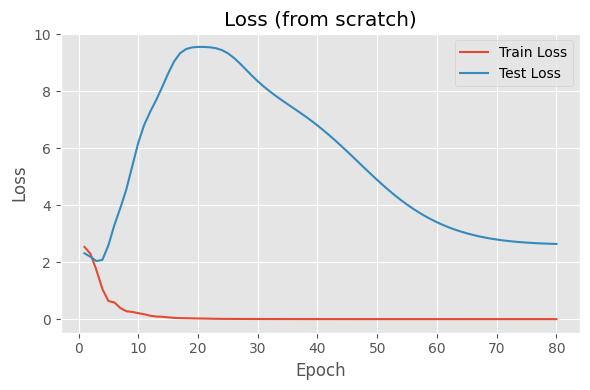

In [16]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss1, label="Train Loss")
plt.plot(epoch_range, test_loss1, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (from scratch)")
plt.legend()
plt.tight_layout()
plt.show()

## (2b) Train only last layer of pre-trained model

Create a new CNNModel, load pre-trained weights, fix the weights of all other layers and only train the last layer. 

Remember to implement what happens when **freeze_layers = True** in the given **train_model()** function.

In [17]:
# Transfer Learning: Freeze all but last layer
model2 = CNNModel()
model2.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.05)
epochs = 80 # TODO
freeze_layers = True
train_loss2, test_loss2, train_acc2, test_acc2 = train_model(model2, train_loader, test_loader, optimizer2, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/80 | Train Loss: 10.3249 | Train Acc: 13.28% | Test Loss: 3.0147 | Test Acc: 39.32%
Epoch  2/80 | Train Loss: 3.4460 | Train Acc: 43.75% | Test Loss: 3.2048 | Test Acc: 56.08%
Epoch  3/80 | Train Loss: 3.1511 | Train Acc: 72.66% | Test Loss: 3.3700 | Test Acc: 59.06%
Epoch  4/80 | Train Loss: 1.9749 | Train Acc: 79.69% | Test Loss: 2.9154 | Test Acc: 61.84%
Epoch  5/80 | Train Loss: 0.6611 | Train Acc: 90.62% | Test Loss: 3.0037 | Test Acc: 63.33%
Epoch  6/80 | Train Loss: 0.4080 | Train Acc: 95.31% | Test Loss: 3.4448 | Test Acc: 63.42%
Epoch  7/80 | Train Loss: 0.5448 | Train Acc: 93.75% | Test Loss: 3.6659 | Test Acc: 64.79%
Epoch  8/80 | Train Loss: 0.3904 | Train Acc: 95.31% | Test Loss: 3.7455 | Test Acc: 66.05%
Epoch  9/80 | Train Loss: 0.1380 | Train Acc: 97.66% | Test Loss: 3.9811 | Test Acc: 66.27%
Epoch 10/80 | Train Loss: 0.0928 | Train Acc: 97.66% | Test Loss: 4.2786 | Test Acc: 66.39%
Epoch 11/80 | Train Loss: 0.0866 | Train Acc: 97.66% | Test Loss: 4.5356 | Test

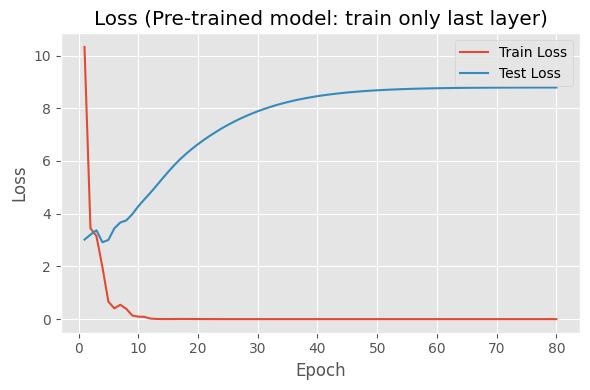

In [18]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss2, label="Train Loss")
plt.plot(epoch_range, test_loss2, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Pre-trained model: train only last layer)")
plt.legend()
plt.tight_layout()
plt.show()

## (2c) Train all layers of pre-trained model

Create a new CNNModel, load pre-trained weights and fine-tune all weights.

In [19]:
model3 = CNNModel()
model3.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)
epochs = 80 # TODO
freeze_layers = False
train_loss3, test_loss3, train_acc3, test_acc3 = train_model(model3, train_loader, test_loader, optimizer3, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/80 | Train Loss: 10.3249 | Train Acc: 13.28% | Test Loss: 2.2430 | Test Acc: 29.70%
Epoch  2/80 | Train Loss: 2.5464 | Train Acc: 40.62% | Test Loss: 2.1010 | Test Acc: 42.66%
Epoch  3/80 | Train Loss: 1.1323 | Train Acc: 64.06% | Test Loss: 2.2624 | Test Acc: 45.03%
Epoch  4/80 | Train Loss: 0.7314 | Train Acc: 74.22% | Test Loss: 1.9308 | Test Acc: 57.67%
Epoch  5/80 | Train Loss: 0.3989 | Train Acc: 83.59% | Test Loss: 1.8112 | Test Acc: 61.76%
Epoch  6/80 | Train Loss: 0.3248 | Train Acc: 87.50% | Test Loss: 1.9029 | Test Acc: 58.87%
Epoch  7/80 | Train Loss: 0.2517 | Train Acc: 89.84% | Test Loss: 2.0201 | Test Acc: 59.11%
Epoch  8/80 | Train Loss: 0.2049 | Train Acc: 93.75% | Test Loss: 2.0425 | Test Acc: 62.29%
Epoch  9/80 | Train Loss: 0.1702 | Train Acc: 95.31% | Test Loss: 1.9814 | Test Acc: 63.44%
Epoch 10/80 | Train Loss: 0.1278 | Train Acc: 96.88% | Test Loss: 1.8812 | Test Acc: 64.94%
Epoch 11/80 | Train Loss: 0.0967 | Train Acc: 97.66% | Test Loss: 1.9258 | Test

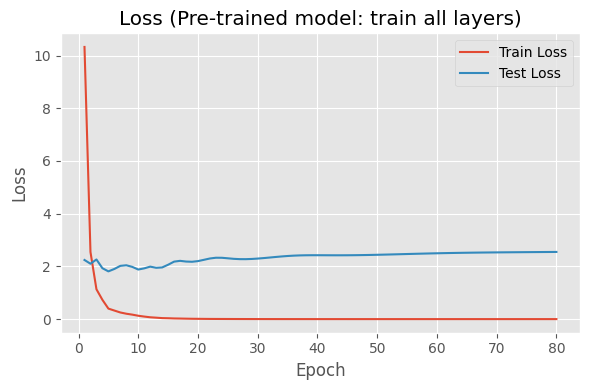

In [ ]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss3, label="Train Loss")
plt.plot(epoch_range, test_loss3, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Pre-trained model: train all layers)")
plt.legend()
plt.tight_layout()
plt.show()

## (2d) Plot and Report

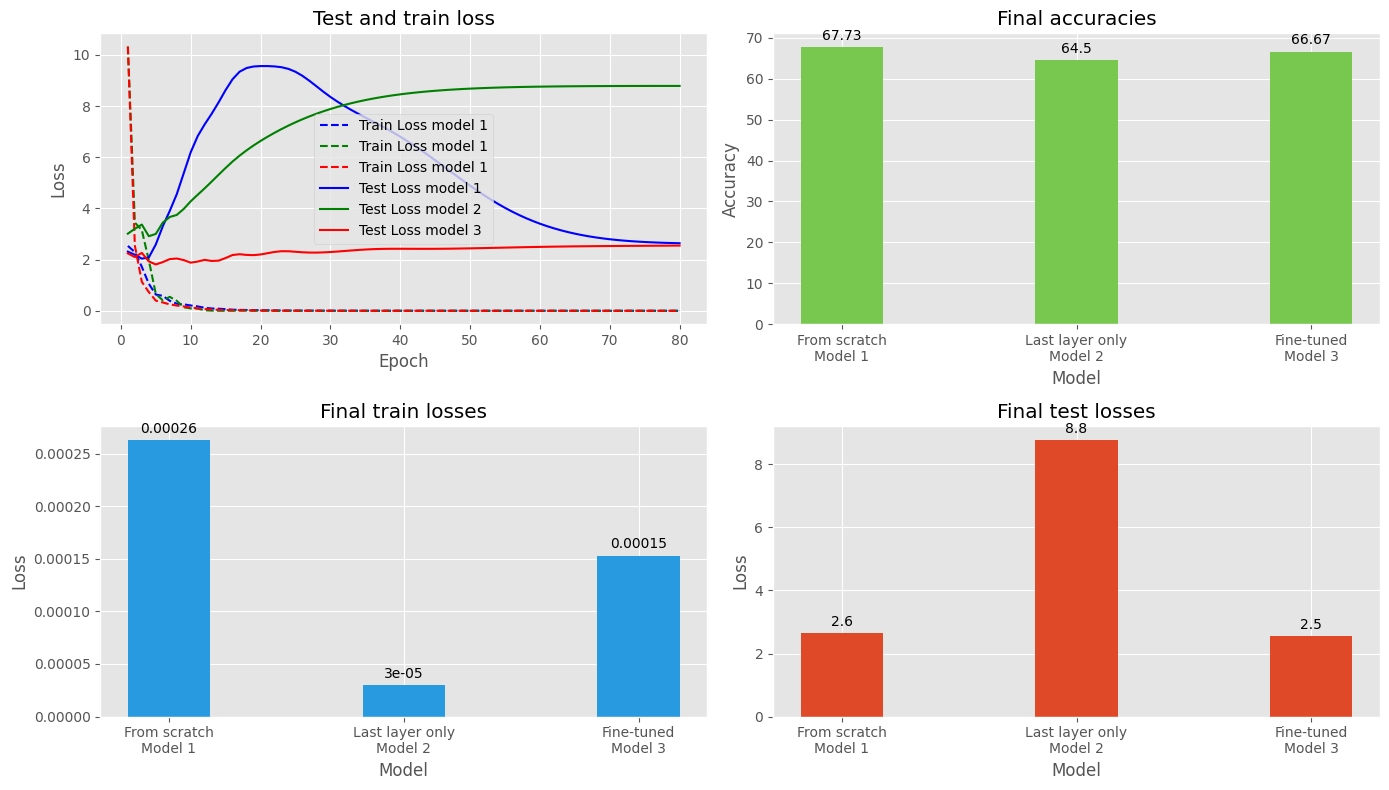

In [43]:
# TODO - Plot
epoch_range = range(1, epochs + 1)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()
width = 0.35
x = np.arange(3)+1  # the label locations


axs[0].plot(epoch_range, train_loss1, "--", label="Train Loss model 1", c = "b")
axs[0].plot(epoch_range, train_loss2, "--", label="Train Loss model 1", c = "g")
axs[0].plot(epoch_range, train_loss3, "--", label="Train Loss model 1", c = "r")
axs[0].plot(epoch_range, test_loss1, label="Test Loss model 1", c = "b")
axs[0].plot(epoch_range, test_loss2, label="Test Loss model 2", c = "g")
axs[0].plot(epoch_range, test_loss3, label="Test Loss model 3", c = "r")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Test and train loss")
axs[0].legend()

labels = ["From scratch\nModel 1", "Last layer only\nModel 2", "Fine-tuned\nModel 3"]
rects = axs[1].bar(x, [test_acc1[-1], test_acc2[-1], test_acc3[-1]], width, color='#78C850')
for rect in rects:
	height = rect.get_height()
	axs[1].annotate('{}'.format(height),
				xy=(rect.get_x() + rect.get_width() / 2, height),
				xytext=(0, 3),  # 3 points vertical offset
				textcoords="offset points",
				ha='center', va='bottom')

axs[1].set_title(f"Final accuracies")
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Accuracy")
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)

rects = axs[2].bar(x, [train_loss1[-1], train_loss2[-1], train_loss3[-1]], width, color='#289BE0')
for rect in rects:
	height = rect.get_height()
	axs[2].annotate('{:.2}'.format(height),
				xy=(rect.get_x() + rect.get_width() / 2, height),
				xytext=(0, 3),  # 3 points vertical offset
				textcoords="offset points",
				ha='center', va='bottom')

axs[2].set_title(f"Final train losses")
axs[2].set_xlabel("Model")
axs[2].set_ylabel("Loss")
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels)

rects = axs[3].bar(x, [test_loss1[-1], test_loss2[-1], test_loss3[-1]], width, color='#E04928')
for rect in rects:
	height = rect.get_height()
	axs[3].annotate('{:.2}'.format(height),
				xy=(rect.get_x() + rect.get_width() / 2, height),
				xytext=(0, 3),  # 3 points vertical offset
				textcoords="offset points",
				ha='center', va='bottom')
axs[3].set_title(f"Final test losses")
axs[3].set_xlabel("Model")
axs[3].set_ylabel("Loss")
axs[3].set_xticks(x)
axs[3].set_xticklabels(labels)

plt.tight_layout()
plt.show()

TODO - Report
As we can see from the plots the final accuracies are somewhat similar, although the best accuracies are achieved by the models trained on all layers. 

From the losses plots we can say that all 3 models are overfitting the dataset given that it is very small (128 examples), since we have low train loss and somewhat high test loss, as expected.

The model trained from scratch performs better than the fine-tuned one suggesting that the MNIST Fashion dataset can not be fit decently by a model trained on MNIST. 

Another interesting finding is that model 2's test loss is much higher than the other two suggesting that model 2 does in fact not update any parameter that does not belong in the last layer and uses it's prior knowledge to misclassify new data more often.

As for computational complexity, the time required for all 3 models is roughly the same (around 2 minutes), suggesting the bottleneck is the evaluation of the dataset multiplied by the number of epochs.

# 3. Few-shot learning

Here **KShotCDataset()** function is given.

It is used to create a FashionMNIST dataloader for a given **K** and **C**.

**DO NOT CHANGE THIS**

In [22]:
from torch.utils.data import Dataset

# Set random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

class KShotCDataset(Dataset):
    def __init__(self, fashion_mnist_dataset, k_shot, c_way):
        self.fashion_mnist_dataset = fashion_mnist_dataset
        self.k_shot = k_shot
        self.c_way = c_way

        self.data_indices = []

        self.class_indices = {label: [] for label in range(self.c_way)}
        self.create_balanced_dataset()

    def create_balanced_dataset(self):
        for idx, (_, label) in enumerate(self.fashion_mnist_dataset):
            if label < self.c_way:
                self.class_indices[label].append(idx)

        for label in range(self.c_way):
            self.data_indices.extend(self.class_indices[label][:self.k_shot])

    def __len__(self):
        return len(self.data_indices)

    def __getitem__(self, index):
        fashion_mnist_index = self.data_indices[index]
        image, label = self.fashion_mnist_dataset[fashion_mnist_index]
        return image, label

# Load the Fashion MNIST training dataset
transform = transforms.Compose([transforms.ToTensor()])
fashionmnist_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

Below, you see an example of how to use **KShotCDataset().**

Implement the algorithm and follow the exercise sheet for details on what to analyse and report.

In [57]:
K = 7  # Number of shots per class
C = 10  # Number of classes -- ordered labels are selected, e.g. C = 3 means labels=[0, 1, 2]
# Create the K-shot C-way dataset
k_shot_c_dataset = KShotCDataset(fashionmnist_dataset, K, C)

dataloader = DataLoader(k_shot_c_dataset, batch_size=K*C, shuffle=True)

model = CNNModel()
model.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
models = [model, model1, model2, model3]
accuracies = []
for net in models:
	net.eval()
	support_features = []
	support_labels = []
	with torch.no_grad():
		for images, labels in train_loader:
			# Extract features (assuming the model has a features method or we can use it up to penultimate layer)
			out = net.MaxPool1(net.bn1(net.relu1(net.cnn1(images))))
			out = net.MaxPool2(net.bn2(net.relu2(net.cnn2(out))))
			out = net.MaxPool3(net.bn3(net.relu3(net.cnn3(out))))
			features = out.view(out.size(0), -1)
			support_features.append(features)
			support_labels.append(labels)

	support_features = torch.cat(support_features, dim=0)
	support_labels = torch.cat(support_labels, dim=0)

	# Extract query features and labels
	query_features = []
	query_labels = []

	with torch.no_grad():
		for images, labels in dataloader:
			out = net.MaxPool1(net.bn1(net.relu1(net.cnn1(images))))
			out = net.MaxPool2(net.bn2(net.relu2(net.cnn2(out))))
			out = net.MaxPool3(net.bn3(net.relu3(net.cnn3(out))))
			features = out.view(out.size(0), -1)
			query_features.append(features)
			query_labels.append(labels)

	query_features = torch.cat(query_features, dim=0)
	query_labels = torch.cat(query_labels, dim=0)

	# center the features
	support_mean = torch.mean(support_features, dim=0, keepdim=True)
	support_centered = support_features - support_mean
	query_centered = query_features - support_mean  # Use support mean for both

	# normalization
	support_norm = torch.norm(support_centered, p=2, dim=1, keepdim=True)
	query_norm = torch.norm(query_centered, p=2, dim=1, keepdim=True)
	support_features_normalized = support_centered / (support_norm + 1e-10)
	query_features_normalized = query_centered / (query_norm + 1e-10)


	# KNN classification for K=1 and K=7
	from sklearn.neighbors import KNeighborsClassifier
	from sklearn.metrics import accuracy_score


	knn_1 = KNeighborsClassifier(n_neighbors=1)
	knn_1.fit(support_features_normalized, support_labels)
	preds = knn_1.predict(query_features_normalized)
	acc = accuracy_score(query_labels, preds)
	accuracies.append(acc * 100)
	print(f"1-NN accuracy: {acc * 100}")

	knn_7 = KNeighborsClassifier(n_neighbors=7)
	knn_7.fit(support_features_normalized, support_labels)
	preds = knn_7.predict(query_features_normalized)
	acc = accuracy_score(query_labels, preds)
	accuracies.append(acc * 100)

	print(f"7-NN accuracy: {acc * 100}")


1-NN accuracy: 70.0
7-NN accuracy: 74.28571428571429
1-NN accuracy: 61.42857142857143
7-NN accuracy: 60.0
1-NN accuracy: 70.0
7-NN accuracy: 65.71428571428571
1-NN accuracy: 71.42857142857143
7-NN accuracy: 72.85714285714285


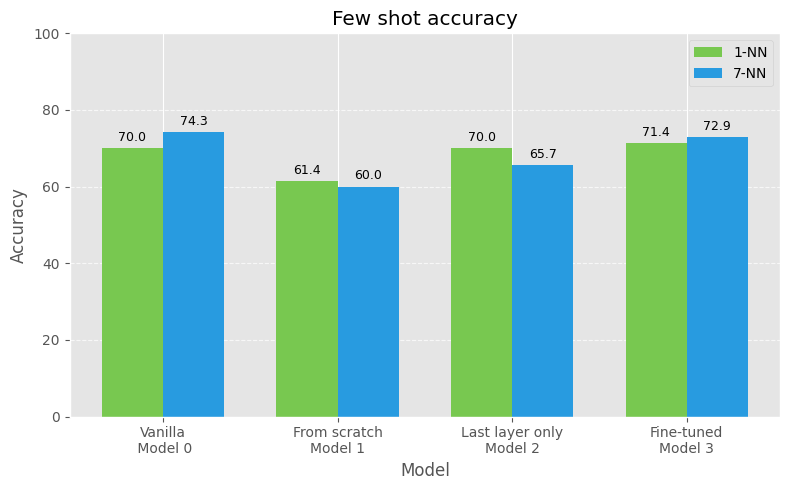

In [61]:
one_nn = accuracies[::2]
seven_nn = accuracies[1::2]

x = np.arange(4)
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, one_nn, width, label='1-NN', color='#78C850')
bars2 = ax.bar(x + width/2, seven_nn, width, label='7-NN', color='#289BE0')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Few shot accuracy')
ax.set_xticks(x)
ax.set_xticklabels(["Vanilla\n Model 0", "From scratch\nModel 1", "Last layer only\nModel 2", "Fine-tuned\nModel 3"])
ax.set_ylim(0, 100)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


TODO - Report

As we can see from the plot the highest accuracy is given by the pretrained model (here called Model 0), not trained on the MNIST Fashion dataset, although ideally in the Few Shot method the feature extractor should to be trained on data coming from the same distribution. The second best result and highest result in 1 shot learning is Model 3, the fine-tuned model trained first on MNIST and later on MNIST Fashion. We can also notice that the worst performance is offered by the model trained from scratch since the feature extractor was trained on a very limited amount of data.